# Autoregressive Integrated Moving Averages- ARIMA(p,d,q)

## Imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv('res/WTI monthly.csv')
df1= df1.dropna()
df1.index = pd.DatetimeIndex(df1['Date'])
df1.index.freq = 'MS'

In [2]:
df1.index

DatetimeIndex(['1986-01-01', '1986-02-01', '1986-03-01', '1986-04-01',
               '1986-05-01', '1986-06-01', '1986-07-01', '1986-08-01',
               '1986-09-01', '1986-10-01',
               ...
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01'],
              dtype='datetime64[ns]', name='Date', length=404, freq='MS')

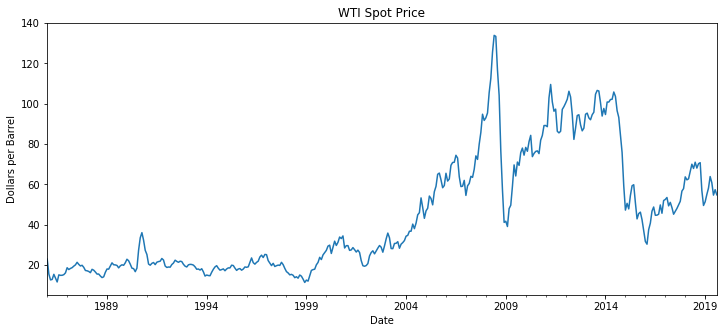

In [4]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'WTI Spot Price'
ylabel='Dollars per Barrel'

ax = df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## Augmented Dickey-Fuller Test
function to determine if the time series is stationary

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string()) # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

### Run the augmented Dickey-Fuller Test

In [14]:
adf_test(df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'])

Augmented Dickey-Fuller Test: WTI Spot Price
ADF test statistic       -1.796895
p-value                   0.382005
# lags used               6.000000
# observations          397.000000
critical value (1%)      -3.446930
critical value (5%)      -2.868848
critical value (10%)     -2.570663
Fail to reject the null hypothesis
Data is non-stationary


ARIMA models apply for non-stationary datasets to make it stationary using differencing.

### Use pmdarima.auto_arima to determine ARIMA Orders

The padarima library utilize the (AIC) as metric to compare the performance of various ARIMA based models.

In [15]:
stepwise_fit = auto_arima(df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'],
                          seasonal=False,
                          m=12,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(2, 1, 2); AIC=2258.724, BIC=2282.718, Fit time=0.328 seconds
Fit ARIMA: order=(0, 1, 0); AIC=2323.778, BIC=2331.775, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2266.047, BIC=2278.044, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2277.947, BIC=2289.943, Fit time=0.324 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2266.991, BIC=2286.985, Fit time=0.123 seconds
Fit ARIMA: order=(3, 1, 2); AIC=2260.239, BIC=2288.231, Fit time=0.368 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2268.150, BIC=2288.145, Fit time=0.142 seconds
Fit ARIMA: order=(2, 1, 3); AIC=2260.395, BIC=2288.388, Fit time=0.410 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2267.552, BIC=2283.548, Fit time=0.080 seconds
Fit ARIMA: order=(3, 1, 3); AIC=2262.301, BIC=2294.293, Fit time=0.603 seconds
Total fit time: 2.518 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  403
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1123.362
Method:                       css-mle   S.D. of innovations              3.928
Date:                Mon, 09 Dec 2019   AIC                           2258.724
Time:                        15:34:48   BIC                           2282.718
Sample:                             1   HQIC                          2268.223
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0881      0.164      0.538      0.591      -0.233       0.409
ar.L1.D.y      1.5008      0.089     16.845      0.000       1.326       1.675
ar.L2.D.y     -0.6080      0.091     -6.713      0.000      -0.785      -0.430
ma.L1.D.y     -1.1652      0.107    -10.866      0.000      -1.375      -0.955
ma.L2.D.y      0.2538      0.110      2.309      0.021       0.038       0.469
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2343           -0.3483j            1.2825           -0.0438
AR.2            1.2343           +0.3483j            1.2825            0.0438
MA.1            1.1426           +0.0000j            1.1426            0.0000
MA.2            3.4479           +0.0000j            3.4479            0.0000
-----------------------------------------------------------------------------
"""

This suggests that an ARIMA(2,1,2) model is the best for forecast future values of oil price.

### Run the augmented Dickey-Fuller Test on the First Difference

using the same differencing order that padarima library suggested to make the dataset stationary.

In [16]:
from statsmodels.tsa.statespace.tools import diff
df1['d1'] = diff(df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'],k_diff=1)

adf_test(df1['d1'])

Augmented Dickey-Fuller Test: WTI Spot Price
ADF test statistic     -9.607867e+00
p-value                 1.845321e-16
# lags used             5.000000e+00
# observations          3.970000e+02
critical value (1%)    -3.446930e+00
critical value (5%)    -2.868848e+00
critical value (10%)   -2.570663e+00
Reject the null hypothesis
Data is stationary


This confirms that the dataset reached stationarity after the first difference.

### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>

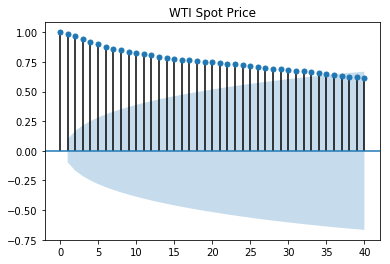

In [17]:
title = 'WTI Spot Price'
lags = 40
plot_acf(df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'],title=title,lags=lags);

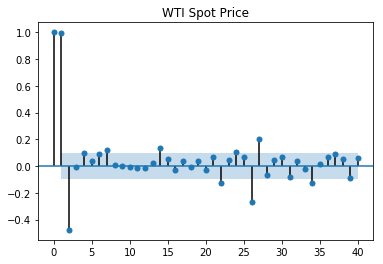

In [18]:
title = 'WTI Spot Price'
lags = 40
plot_pacf(df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'],title=title,lags=lags);

This tells us that

### Split the data into train/test sets

In [19]:
len(df1)

404

In [20]:
# Set four month for testing
train = df1.iloc[:-12]
test = df1.iloc[len(df1)-12:]

### Fit an ARIMA(2,1,2) Model

In [23]:
model = ARIMA(train['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'],order=(2,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                               ARIMA Model Results                                               
=================================================================================================================
Dep. Variable:     D.Cushing, OK WTI Spot Price FOB (Dollars per Barrel)   No. Observations:                  391
Model:                                                    ARIMA(2, 1, 2)   Log Likelihood               -1088.783
Method:                                                          css-mle   S.D. of innovations              3.917
Date:                                                   Mon, 09 Dec 2019   AIC                           2189.566
Time:                                                           15:38:35   BIC                           2213.378
Sample:                                                       02-01-1986   HQIC                          2199.004
                                                            - 08-01-2018                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                           0.0997      0.322      0.310      0.757      -0.531       0.730
ar.L1.D.Cushing, OK WTI Spot Price FOB (Dollars per Barrel)    -0.0300      0.313     -0.096      0.924      -0.643       0.583
ar.L2.D.Cushing, OK WTI Spot Price FOB (Dollars per Barrel)     0.0768      0.175      0.438      0.662      -0.267       0.420
ma.L1.D.Cushing, OK WTI Spot Price FOB (Dollars per Barrel)     0.3911      0.311      1.259      0.209      -0.218       1.000
ma.L2.D.Cushing, OK WTI Spot Price FOB (Dollars per Barrel)     0.1595      0.129      1.241      0.215      -0.092       0.411
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4192           +0.0000j            3.4192            0.5000
AR.2            3.8100           +0.0000j            3.8100            0.0000
MA.1           -1.2260           -2.1833j            2.5040           -0.3314
MA.2           -1.2260           +2.1833j            2.5040            0.3314
-----------------------------------------------------------------------------
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) Predictions')

In [25]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'][i]}")

predicted=67.66486685895605, expected=70.23
predicted=66.96614277235487, expected=70.75
predicted=67.05183760451763, expected=56.96
predicted=67.09069580104246, expected=49.52
predicted=67.19117271220216, expected=51.38
predicted=67.2862058004062, expected=54.95
predicted=67.38613218258075, expected=58.15
predicted=67.48549388803801, expected=63.86
predicted=67.58524815307273, expected=60.83
predicted=67.68494729566306, expected=54.66
predicted=67.78467822560205, expected=57.35
predicted=67.88440397061537, expected=54.81


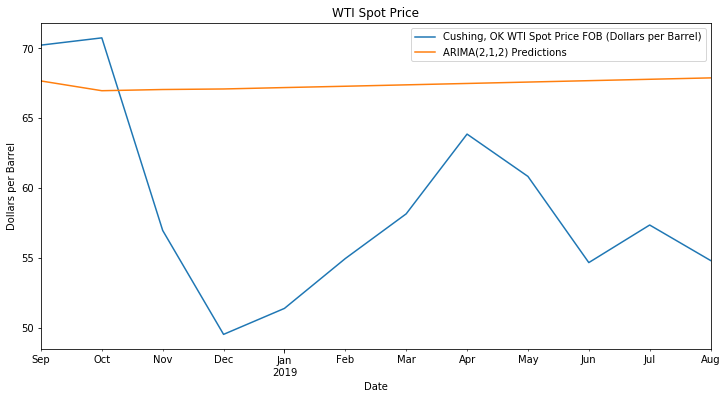

In [27]:
# Plot predictions against known values
title = 'WTI Spot Price'
ylabel='Dollars per Barrel'

ax = test['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [28]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'], predictions)
print(f'ARIMA(2,1,2) MSE Error: {error}')

ARIMA(2,1,2) MSE Error: 118.93355824613893


In [29]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'], predictions)
print(f'ARIMA(2,1,2) RMSE Error: {error}')

ARIMA(2,1,2) RMSE Error: 10.905666336640735


In [30]:
test['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'].mean()

58.62083333333334

### Retrain the model on the full data, and forecast the future

In [33]:
model = ARIMA(df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'],order=(2,1,2))
results = model.fit()
fcast = results.predict(len(df1),len(df1)+11,typ='levels').rename('ARIMA(2,1,2) Forecast')

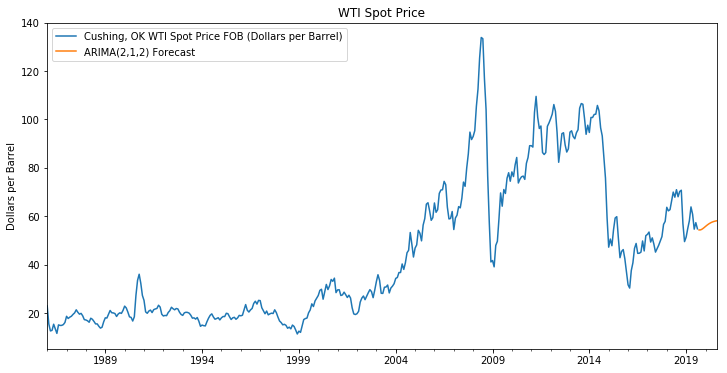

In [34]:
# Plot predictions against known values
title = 'WTI Spot Price'
ylabel='Dollars per Barrel'
xlabel='' # we don't really need a label here

ax = df1['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);